In [1]:
from __future__ import division
import numpy as np
from graphviz import Source
from qnetwork import *
from utils import *
import matplotlib.pyplot as plt
from env import *
from Plot_Path import *
import tensorflow as tf

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def train(sess, env, qnet):
    
    global EXPLORATION_RATE
  
    summary_ops, summary_vars = build_summaries()

    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(SUMMARY_DIR, sess.graph)
    
    qnet.update_target()
    
    replay_buffer = ReplayBuffer(BUFFER_SIZE, RANDOM_SEED)
    
    for num_epi in range(MAX_EPISODES):

        s = env.reset()
        s = [list(np.unravel_index(s, env.shape))]

        ep_reward = 0
        ep_ave_max_q = 0
        
        reward_list = []

        for j in range(MAX_EPISODE_LEN):

            a = np.argmax(qnet.predict_q(np.reshape(s, (1, qnet.state_dim))))
    
            if np.random.rand(1) < EXPLORATION_RATE:
                s2, r, terminal, info = env.step(np.random.randint(0,qnet.action_dim))
            else:
                s2, r, terminal, info = env.step(a)
            
            s2 = list(np.unravel_index(s2, env.shape))

            replay_buffer.add(np.reshape(s, (qnet.state_dim,)), np.reshape(a, (1,)), r,
                              terminal, np.reshape(s2, (qnet.state_dim,)))

            # Keep adding experience to the memory until
            # there are at least minibatch size samples
            if replay_buffer.size() > MINIBATCH_SIZE:
                s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(MINIBATCH_SIZE)

                # Calculate targets
                target_q = qnet.predect_target(s2_batch)

                y_i = []
                for k in range(MINIBATCH_SIZE):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + GAMMA * np.amax(target_q[k]))

                # Update the critic given the targets
                predicted_q_value, _ = qnet.train(s_batch, a_batch, np.reshape(y_i, (MINIBATCH_SIZE, 1)), num_epi)

                ep_ave_max_q += np.amax(predicted_q_value)
                
                # Update target networks
                qnet.update_target()

            s = s2
            ep_reward += r

            if terminal or j == MAX_EPISODE_LEN-1:
                
                if EXPLORATION_RATE > 0.02 and terminal:
                    EXPLORATION_RATE = EXPLORATION_RATE*0.92
                    
                reward_list += [ep_reward]
                
                if np.average(reward_list[-10:]) > LR_DECAY_TRUNCATION:
                    qnet.decay_learning_rate(0.92)

                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: ep_reward,
                    summary_vars[1]: ep_ave_max_q / float(j),
                    summary_vars[2]: EXPLORATION_RATE,
                    summary_vars[3]: qnet.get_learning_rate()                    
                })

                writer.add_summary(summary_str, num_epi)
                writer.flush()

                print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f} | Exploration: {:.6f} '.format(int(ep_reward), \
                        num_epi, (ep_ave_max_q / float(j)), EXPLORATION_RATE))
                
                f = open("stats.txt", "ab")
                f.write("| Reward: " + str(int(ep_reward)) 
                        +" | Episode: " + str(num_epi) 
                        + " | Qmax: " + str(ep_ave_max_q / float(j)) 
                        + " | Exploration: " + str(EXPLORATION_RATE) + "\n")
                f.close()
                
                break
                
        if num_epi%10 == 0:
            state_list = []
            action_list = []
            world = np.zeros(env.shape)
            for state in range(env.nS):
                state = np.unravel_index(state, env.shape)
                action = qnet.predict_q(np.reshape(state, (1,state_dim)))
                action = np.argmax(action)
                state_list.append(state)
                action_list.append(action)
                
#             print np.reshape(action_list, env.shape)
                
            f = open("action.txt","ab")
            act_string = np.array_str(np.reshape(action_list, env.shape))
            f.write(act_string)
            f.write("---------------------------\n")
            f.close()
    
    

In [3]:
LEARNING_RATE = 0.0015
GAMMA = 0.99
# GAMMA = 0.7
TAU = 0.001
BUFFER_SIZE = 10**6
MINIBATCH_SIZE = 64
RANDOM_SEED = 666
MAX_EPISODES = 50000
MAX_EPISODE_LEN = 500
file_appendix = time.ctime()[4:16].replace("  ","").replace(" ","_").replace(":","-")
SUMMARY_DIR = './results/tf_ddqn_' + file_appendix
SAVE_DIR = "./saved_model/" + file_appendix + "/ddqn.ckpt"
EXPLORATION_RATE = 0.65
LR_DECAY_TRUNCATION = -200

LTL = "<>(A && <>B) && []!C"

0
0


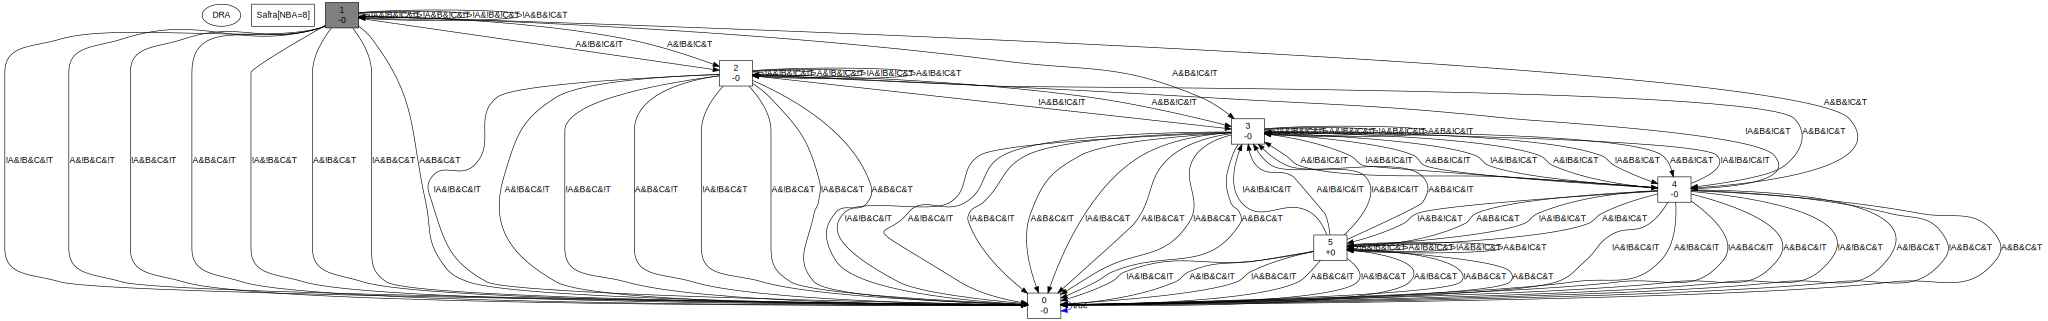

In [ ]:
env = CurrentWorld(LTL)
with open("my.dot", "r") as dotfile:
    text = dotfile.read()
Source(text)

In [ ]:
with tf.Session() as sess:
    
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    env.seed(RANDOM_SEED)
    
    state_dim = 3
    action_dim = 4
    
    Qnet = QNet(sess, state_dim, action_dim, LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)
    
    train(sess, env, Qnet)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


DDQN Saved
| Reward: -14360 | Episode: 0 | Qmax: -10.0515 | Exploration: 0.650000 
| Reward: -14810 | Episode: 1 | Qmax: -29.5072 | Exploration: 0.650000 
| Reward: -11300 | Episode: 2 | Qmax: -38.4192 | Exploration: 0.650000 
| Reward: -9860 | Episode: 3 | Qmax: -41.4561 | Exploration: 0.650000 
| Reward: -10220 | Episode: 4 | Qmax: -44.3152 | Exploration: 0.650000 
| Reward: -10130 | Episode: 5 | Qmax: -51.9411 | Exploration: 0.650000 
| Reward: -10670 | Episode: 6 | Qmax: -59.5389 | Exploration: 0.650000 
| Reward: -8690 | Episode: 7 | Qmax: -65.7679 | Exploration: 0.650000 
| Reward: -10760 | Episode: 8 | Qmax: -71.8296 | Exploration: 0.650000 
| Reward: -9860 | Episode: 9 | Qmax: -78.1616 | Exploration: 0.650000 
| Reward: -9320 | Episode: 10 | Qmax: -84.0867 | Exploration: 0.650000 
| Reward: -8420 | Episode: 11 | Qmax: -89.5989 | Exploration: 0.650000 
| Reward: -6980 | Episode: 12 | Qmax: -95.5791 | Exploration: 0.650000 
| Reward: -10310 | Episode: 13 | Qmax: -100.0799 | Explo

| Reward: -8240 | Episode: 112 | Qmax: -664.6997 | Exploration: 0.650000 
| Reward: -8420 | Episode: 113 | Qmax: -668.2462 | Exploration: 0.650000 
| Reward: -8780 | Episode: 114 | Qmax: -673.8889 | Exploration: 0.650000 
| Reward: -7160 | Episode: 115 | Qmax: -678.9870 | Exploration: 0.650000 
| Reward: -7250 | Episode: 116 | Qmax: -682.8439 | Exploration: 0.650000 
| Reward: -7880 | Episode: 117 | Qmax: -687.2996 | Exploration: 0.650000 
| Reward: -8240 | Episode: 118 | Qmax: -691.5057 | Exploration: 0.650000 
| Reward: -7700 | Episode: 119 | Qmax: -696.5997 | Exploration: 0.650000 
DDQN Saved
| Reward: -7880 | Episode: 120 | Qmax: -700.0682 | Exploration: 0.650000 
| Reward: -8420 | Episode: 121 | Qmax: -704.5188 | Exploration: 0.650000 
| Reward: -9140 | Episode: 122 | Qmax: -709.4052 | Exploration: 0.650000 
| Reward: -8510 | Episode: 123 | Qmax: -713.4995 | Exploration: 0.650000 
| Reward: -8870 | Episode: 124 | Qmax: -717.9270 | Exploration: 0.650000 
| Reward: -9320 | Episode: 

| Reward: -7250 | Episode: 222 | Qmax: -1018.6384 | Exploration: 0.333592 
| Reward: -6980 | Episode: 223 | Qmax: -1019.7838 | Exploration: 0.333592 
| Reward: -5900 | Episode: 224 | Qmax: -1019.8768 | Exploration: 0.333592 
| Reward: -7070 | Episode: 225 | Qmax: -1020.3590 | Exploration: 0.333592 
| Reward: -6350 | Episode: 226 | Qmax: -1020.7102 | Exploration: 0.333592 
| Reward: -6350 | Episode: 227 | Qmax: -1021.6907 | Exploration: 0.333592 
| Reward: -6080 | Episode: 228 | Qmax: -1026.0425 | Exploration: 0.333592 
| Reward: -6440 | Episode: 229 | Qmax: -1026.6896 | Exploration: 0.333592 
| Reward: -7160 | Episode: 230 | Qmax: -1027.7171 | Exploration: 0.333592 
| Reward: -6080 | Episode: 231 | Qmax: -1028.6218 | Exploration: 0.333592 
| Reward: -6620 | Episode: 232 | Qmax: -1032.4859 | Exploration: 0.333592 
| Reward: -6440 | Episode: 233 | Qmax: -1034.6898 | Exploration: 0.333592 
| Reward: -7610 | Episode: 234 | Qmax: -1036.9524 | Exploration: 0.333592 
| Reward: -6350 | Episode

| Reward: -6260 | Episode: 331 | Qmax: -1109.1242 | Exploration: 0.157509 
| Reward: -6890 | Episode: 332 | Qmax: -1106.8592 | Exploration: 0.157509 
| Reward: -7160 | Episode: 333 | Qmax: -1107.0831 | Exploration: 0.157509 
| Reward: -6620 | Episode: 334 | Qmax: -1104.6477 | Exploration: 0.157509 
| Reward: -6170 | Episode: 335 | Qmax: -1098.9822 | Exploration: 0.157509 
| Reward: -5720 | Episode: 336 | Qmax: -1093.2534 | Exploration: 0.157509 
| Reward: -5450 | Episode: 337 | Qmax: -1097.2749 | Exploration: 0.157509 
| Reward: -6440 | Episode: 338 | Qmax: -1086.3516 | Exploration: 0.157509 
| Reward: -5990 | Episode: 339 | Qmax: -1094.0108 | Exploration: 0.157509 
DDQN Saved
| Reward: -5990 | Episode: 340 | Qmax: -1080.4514 | Exploration: 0.157509 
| Reward: -6080 | Episode: 341 | Qmax: -1080.9150 | Exploration: 0.157509 
| Reward: -6260 | Episode: 342 | Qmax: -1102.4786 | Exploration: 0.157509 
| Reward: -5990 | Episode: 343 | Qmax: -1087.3336 | Exploration: 0.157509 
| Reward: -599

| Reward: -1550 | Episode: 441 | Qmax: -734.9719 | Exploration: 0.019589 
| Reward: -4070 | Episode: 442 | Qmax: -745.1670 | Exploration: 0.019589 
| Reward: -650 | Episode: 443 | Qmax: -813.6363 | Exploration: 0.019589 
| Reward: -330 | Episode: 444 | Qmax: -779.6277 | Exploration: 0.019589 
| Reward: -2200 | Episode: 445 | Qmax: -721.4678 | Exploration: 0.019589 
| Reward: -2950 | Episode: 446 | Qmax: -678.9873 | Exploration: 0.019589 
| Reward: -1290 | Episode: 447 | Qmax: -730.0235 | Exploration: 0.019589 
| Reward: -1810 | Episode: 448 | Qmax: -724.4729 | Exploration: 0.019589 
| Reward: -670 | Episode: 449 | Qmax: -693.1362 | Exploration: 0.019589 
| Reward: -5360 | Episode: 450 | Qmax: -674.0743 | Exploration: 0.019589 
| Reward: -600 | Episode: 451 | Qmax: -712.0248 | Exploration: 0.019589 
| Reward: -840 | Episode: 452 | Qmax: -683.5129 | Exploration: 0.019589 
| Reward: -4850 | Episode: 453 | Qmax: -691.1144 | Exploration: 0.019589 
| Reward: -1470 | Episode: 454 | Qmax: -665

| Reward: -4850 | Episode: 552 | Qmax: -345.0745 | Exploration: 0.019589 
| Reward: -220 | Episode: 553 | Qmax: -339.0819 | Exploration: 0.019589 
| Reward: -1220 | Episode: 554 | Qmax: -337.1439 | Exploration: 0.019589 
| Reward: -1400 | Episode: 555 | Qmax: -340.2371 | Exploration: 0.019589 
| Reward: -1180 | Episode: 556 | Qmax: -323.2509 | Exploration: 0.019589 
| Reward: -5020 | Episode: 557 | Qmax: -339.1646 | Exploration: 0.019589 
| Reward: -2260 | Episode: 558 | Qmax: -325.0487 | Exploration: 0.019589 
| Reward: -890 | Episode: 559 | Qmax: -325.4718 | Exploration: 0.019589 
DDQN Saved
| Reward: -3730 | Episode: 560 | Qmax: -278.4379 | Exploration: 0.019589 
| Reward: -7430 | Episode: 561 | Qmax: -314.8766 | Exploration: 0.019589 
| Reward: -5170 | Episode: 562 | Qmax: -303.8687 | Exploration: 0.019589 
| Reward: -1410 | Episode: 563 | Qmax: -256.3415 | Exploration: 0.019589 
| Reward: -1590 | Episode: 564 | Qmax: -277.5337 | Exploration: 0.019589 
| Reward: -2700 | Episode: 56

| Reward: -2890 | Episode: 663 | Qmax: -227.5869 | Exploration: 0.019589 
| Reward: -750 | Episode: 664 | Qmax: -228.3241 | Exploration: 0.019589 
| Reward: -520 | Episode: 665 | Qmax: -283.6394 | Exploration: 0.019589 
| Reward: -2230 | Episode: 666 | Qmax: -240.4214 | Exploration: 0.019589 
| Reward: -1420 | Episode: 667 | Qmax: -211.0667 | Exploration: 0.019589 
| Reward: -3780 | Episode: 668 | Qmax: -226.5831 | Exploration: 0.019589 
| Reward: -1190 | Episode: 669 | Qmax: -234.3854 | Exploration: 0.019589 
| Reward: -1660 | Episode: 670 | Qmax: -226.0324 | Exploration: 0.019589 
| Reward: -2340 | Episode: 671 | Qmax: -185.2912 | Exploration: 0.019589 
| Reward: -210 | Episode: 672 | Qmax: -185.6608 | Exploration: 0.019589 
| Reward: -2330 | Episode: 673 | Qmax: -192.0586 | Exploration: 0.019589 
| Reward: -120 | Episode: 674 | Qmax: -317.6064 | Exploration: 0.019589 
| Reward: -2470 | Episode: 675 | Qmax: -197.0797 | Exploration: 0.019589 
| Reward: -260 | Episode: 676 | Qmax: -218

| Reward: -240 | Episode: 774 | Qmax: -175.8738 | Exploration: 0.019589 
| Reward: -4340 | Episode: 775 | Qmax: -179.4055 | Exploration: 0.019589 
| Reward: -3380 | Episode: 776 | Qmax: -188.1719 | Exploration: 0.019589 
| Reward: -3170 | Episode: 777 | Qmax: -207.9279 | Exploration: 0.019589 
| Reward: -760 | Episode: 778 | Qmax: -219.1526 | Exploration: 0.019589 
| Reward: -900 | Episode: 779 | Qmax: -160.5899 | Exploration: 0.019589 
DDQN Saved
| Reward: -1280 | Episode: 780 | Qmax: -174.6778 | Exploration: 0.019589 
| Reward: -2800 | Episode: 781 | Qmax: -187.9281 | Exploration: 0.019589 
| Reward: -2190 | Episode: 782 | Qmax: -159.0587 | Exploration: 0.019589 
| Reward: -530 | Episode: 783 | Qmax: -187.6604 | Exploration: 0.019589 
| Reward: -210 | Episode: 784 | Qmax: -238.5861 | Exploration: 0.019589 
| Reward: -910 | Episode: 785 | Qmax: -170.4227 | Exploration: 0.019589 
| Reward: -450 | Episode: 786 | Qmax: -168.8439 | Exploration: 0.019589 
| Reward: -1190 | Episode: 787 | Q

| Reward: -1300 | Episode: 885 | Qmax: -135.1541 | Exploration: 0.019589 
| Reward: -240 | Episode: 886 | Qmax: -202.8231 | Exploration: 0.019589 
| Reward: -4030 | Episode: 887 | Qmax: -164.0029 | Exploration: 0.019589 
| Reward: -570 | Episode: 888 | Qmax: -167.0559 | Exploration: 0.019589 
| Reward: -1420 | Episode: 889 | Qmax: -110.0332 | Exploration: 0.019589 
| Reward: -760 | Episode: 890 | Qmax: -116.9329 | Exploration: 0.019589 
| Reward: -980 | Episode: 891 | Qmax: -151.7965 | Exploration: 0.019589 
| Reward: -2290 | Episode: 892 | Qmax: -140.6064 | Exploration: 0.019589 
| Reward: -310 | Episode: 893 | Qmax: -116.7641 | Exploration: 0.019589 
| Reward: -1740 | Episode: 894 | Qmax: -138.2632 | Exploration: 0.019589 
| Reward: -880 | Episode: 895 | Qmax: -112.7463 | Exploration: 0.019589 
| Reward: -590 | Episode: 896 | Qmax: -148.6978 | Exploration: 0.019589 
| Reward: -2130 | Episode: 897 | Qmax: -161.7395 | Exploration: 0.019589 
| Reward: -310 | Episode: 898 | Qmax: -151.25

| Reward: -540 | Episode: 996 | Qmax: -82.2746 | Exploration: 0.019589 
| Reward: -350 | Episode: 997 | Qmax: -122.9250 | Exploration: 0.019589 
| Reward: -240 | Episode: 998 | Qmax: -152.6353 | Exploration: 0.019589 
| Reward: -400 | Episode: 999 | Qmax: -161.3847 | Exploration: 0.019589 
DDQN Saved
| Reward: -1110 | Episode: 1000 | Qmax: -137.8980 | Exploration: 0.019589 
| Reward: -430 | Episode: 1001 | Qmax: -104.9114 | Exploration: 0.019589 
| Reward: -250 | Episode: 1002 | Qmax: -129.8928 | Exploration: 0.019589 
| Reward: -1760 | Episode: 1003 | Qmax: -109.9984 | Exploration: 0.019589 
| Reward: -1080 | Episode: 1004 | Qmax: -151.3996 | Exploration: 0.019589 
| Reward: -1190 | Episode: 1005 | Qmax: -138.8593 | Exploration: 0.019589 
| Reward: -150 | Episode: 1006 | Qmax: -125.1982 | Exploration: 0.019589 
| Reward: -230 | Episode: 1007 | Qmax: -100.8637 | Exploration: 0.019589 
| Reward: -710 | Episode: 1008 | Qmax: -91.3100 | Exploration: 0.019589 
| Reward: -3350 | Episode: 10

| Reward: -300 | Episode: 1106 | Qmax: -104.6982 | Exploration: 0.019589 
| Reward: -610 | Episode: 1107 | Qmax: -101.8714 | Exploration: 0.019589 
| Reward: -280 | Episode: 1108 | Qmax: -93.1988 | Exploration: 0.019589 
| Reward: -5420 | Episode: 1109 | Qmax: -89.5251 | Exploration: 0.019589 
| Reward: -2120 | Episode: 1110 | Qmax: -82.0821 | Exploration: 0.019589 
| Reward: -430 | Episode: 1111 | Qmax: -70.7675 | Exploration: 0.019589 
| Reward: -1090 | Episode: 1112 | Qmax: -100.9757 | Exploration: 0.019589 
| Reward: -1260 | Episode: 1113 | Qmax: -73.0797 | Exploration: 0.019589 
| Reward: -220 | Episode: 1114 | Qmax: -127.9609 | Exploration: 0.019589 
| Reward: -2160 | Episode: 1115 | Qmax: -87.4141 | Exploration: 0.019589 
| Reward: -460 | Episode: 1116 | Qmax: -86.7073 | Exploration: 0.019589 
| Reward: -230 | Episode: 1117 | Qmax: -76.2867 | Exploration: 0.019589 
| Reward: -310 | Episode: 1118 | Qmax: -78.7585 | Exploration: 0.019589 
| Reward: -1020 | Episode: 1119 | Qmax: -5

| Reward: -290 | Episode: 1217 | Qmax: -56.7535 | Exploration: 0.019589 
| Reward: -700 | Episode: 1218 | Qmax: -25.8445 | Exploration: 0.019589 
| Reward: -1130 | Episode: 1219 | Qmax: -42.3877 | Exploration: 0.019589 
DDQN Saved
| Reward: -180 | Episode: 1220 | Qmax: -37.1147 | Exploration: 0.019589 
| Reward: -1190 | Episode: 1221 | Qmax: -68.3160 | Exploration: 0.019589 
| Reward: -3510 | Episode: 1222 | Qmax: -61.1813 | Exploration: 0.019589 
| Reward: -2070 | Episode: 1223 | Qmax: -69.8884 | Exploration: 0.019589 
| Reward: -630 | Episode: 1224 | Qmax: -7.3259 | Exploration: 0.019589 
| Reward: -1010 | Episode: 1225 | Qmax: -51.1694 | Exploration: 0.019589 
| Reward: -260 | Episode: 1226 | Qmax: -42.5789 | Exploration: 0.019589 
| Reward: -1490 | Episode: 1227 | Qmax: -78.7892 | Exploration: 0.019589 
| Reward: -200 | Episode: 1228 | Qmax: -50.0367 | Exploration: 0.019589 
| Reward: -110 | Episode: 1229 | Qmax: -70.0662 | Exploration: 0.019589 
| Reward: -2360 | Episode: 1230 | Q

| Reward: -160 | Episode: 1328 | Qmax: -2.7209 | Exploration: 0.019589 
| Reward: -310 | Episode: 1329 | Qmax: -31.9576 | Exploration: 0.019589 
| Reward: -590 | Episode: 1330 | Qmax: -53.5109 | Exploration: 0.019589 
| Reward: -300 | Episode: 1331 | Qmax: -57.2112 | Exploration: 0.019589 
| Reward: -470 | Episode: 1332 | Qmax: -31.1405 | Exploration: 0.019589 
| Reward: -340 | Episode: 1333 | Qmax: -40.1773 | Exploration: 0.019589 
| Reward: -100 | Episode: 1334 | Qmax: -18.4277 | Exploration: 0.019589 
| Reward: -1180 | Episode: 1335 | Qmax: -70.3677 | Exploration: 0.019589 
| Reward: -280 | Episode: 1336 | Qmax: -41.5769 | Exploration: 0.019589 
| Reward: -150 | Episode: 1337 | Qmax: -1.7477 | Exploration: 0.019589 
| Reward: -2340 | Episode: 1338 | Qmax: -42.2230 | Exploration: 0.019589 
| Reward: -160 | Episode: 1339 | Qmax: -31.6174 | Exploration: 0.019589 
DDQN Saved
| Reward: -190 | Episode: 1340 | Qmax: -58.3782 | Exploration: 0.019589 
| Reward: -1170 | Episode: 1341 | Qmax: 

| Reward: -190 | Episode: 1440 | Qmax: -81.0079 | Exploration: 0.019589 
| Reward: -1780 | Episode: 1441 | Qmax: -53.9395 | Exploration: 0.019589 
| Reward: -2020 | Episode: 1442 | Qmax: -6.7433 | Exploration: 0.019589 
| Reward: -360 | Episode: 1443 | Qmax: -14.7400 | Exploration: 0.019589 
| Reward: -1930 | Episode: 1444 | Qmax: -40.4514 | Exploration: 0.019589 
| Reward: -120 | Episode: 1445 | Qmax: -27.5708 | Exploration: 0.019589 
| Reward: -210 | Episode: 1446 | Qmax: -42.2231 | Exploration: 0.019589 
| Reward: -200 | Episode: 1447 | Qmax: -5.5855 | Exploration: 0.019589 
| Reward: -550 | Episode: 1448 | Qmax: -23.5025 | Exploration: 0.019589 
| Reward: -1480 | Episode: 1449 | Qmax: -24.8802 | Exploration: 0.019589 
| Reward: -880 | Episode: 1450 | Qmax: -8.0872 | Exploration: 0.019589 
| Reward: -610 | Episode: 1451 | Qmax: -11.3373 | Exploration: 0.019589 
| Reward: -200 | Episode: 1452 | Qmax: 7.6546 | Exploration: 0.019589 
| Reward: -370 | Episode: 1453 | Qmax: -18.1434 | Ex

| Reward: -720 | Episode: 1552 | Qmax: 2.6920 | Exploration: 0.019589 
| Reward: -200 | Episode: 1553 | Qmax: -8.3301 | Exploration: 0.019589 
| Reward: -160 | Episode: 1554 | Qmax: 10.9283 | Exploration: 0.019589 
| Reward: -1890 | Episode: 1555 | Qmax: -44.9047 | Exploration: 0.019589 
| Reward: -410 | Episode: 1556 | Qmax: -4.2526 | Exploration: 0.019589 
| Reward: -160 | Episode: 1557 | Qmax: 3.4572 | Exploration: 0.019589 
| Reward: -2020 | Episode: 1558 | Qmax: -7.6423 | Exploration: 0.019589 
| Reward: -330 | Episode: 1559 | Qmax: 6.2454 | Exploration: 0.019589 
DDQN Saved
| Reward: -180 | Episode: 1560 | Qmax: -55.8932 | Exploration: 0.019589 
| Reward: -310 | Episode: 1561 | Qmax: -22.8761 | Exploration: 0.019589 
| Reward: -360 | Episode: 1562 | Qmax: -32.1227 | Exploration: 0.019589 
| Reward: -240 | Episode: 1563 | Qmax: 25.7305 | Exploration: 0.019589 
| Reward: -240 | Episode: 1564 | Qmax: -19.5413 | Exploration: 0.019589 
| Reward: -220 | Episode: 1565 | Qmax: -9.6605 | 

In [ ]:
plot_path(env, LTL, "./saved_model/Feb8_22-20/ddqn.ckpt", LEARNING_RATE, TAU, MINIBATCH_SIZE, SAVE_DIR)

In [ ]:
plt.close("all")

In [ ]:
ns = np.unravel_index(env.reset(), env.shape)[:2]

In [ ]:
action = 1
ns, _, _, _ = env.step(action)
ns = np.unravel_index(ns, env.shape)
render(env, ns[:2], action)